# =============================
#   F21AA Applied Text Analytics 
#   Coursework 2
# =============================

# =============================
#  0. Installation/Imports
# =============================

In [2]:
# =============================
#   F21AA Applied Text Analytics 
#   Coursework 2
# =============================

# =============================
#  0. Installation/Imports
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk

# If you haven't downloaded NLTK resources, uncomment the following lines:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Example classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# For deep learning-based model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

# For topic modeling
!pip install gensim --quiet
import gensim
from gensim import corpora

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')


# =============================
#  1. Data Loading and Initial Exploration
# =============================

In [4]:


# Replace with your actual paths to train.csv and test.csv
TRAIN_DATA_PATH = "train.csv"
TEST_DATA_PATH  = "test.csv"

# For demonstration, this code assumes each CSV has the following columns:
# train.csv: "reviewText", "rating"
# test.csv : "reviewText" (no rating)
# Adjust column names as necessary.

# Load the data
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test  = pd.read_csv(TEST_DATA_PATH)

print("Train set size:", df_train.shape)
print("Test set size:", df_test.shape)

# Check for nulls
print("\nNumber of nulls in train data:\n", df_train.isnull().sum())
print("\nSample rows from training data:\n", df_train.head())


Train set size: (309131, 2)
Test set size: (119662, 2)

Number of nulls in train data:
 Score    0
Text     0
dtype: int64

Sample rows from training data:
    Score                                               Text
0      5  I received this product early from the seller!...
1      5  *****<br />Numi's Collection Assortment Melang...
2      5  I was very careful not to overcook this pasta,...
3      5  Buying this multi-pack I was misled by the pic...
4      5  These bars are so good! I loved them warmed up...


# =============================
#  1.a Basic Data Exploration
# =============================


Distribution of Ratings:
 Score
1     28521
2     16287
3     23296
4     43876
5    197151
Name: count, dtype: int64


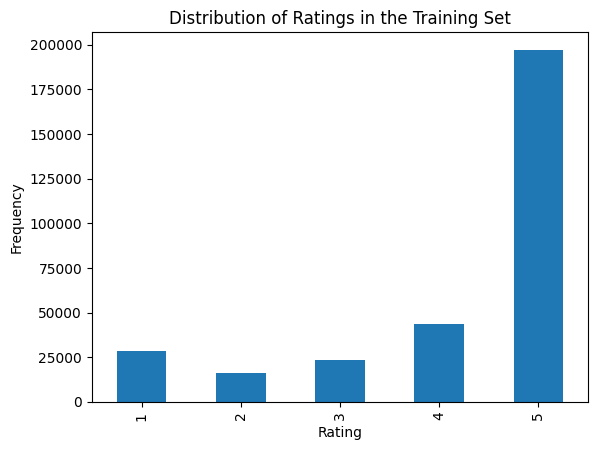

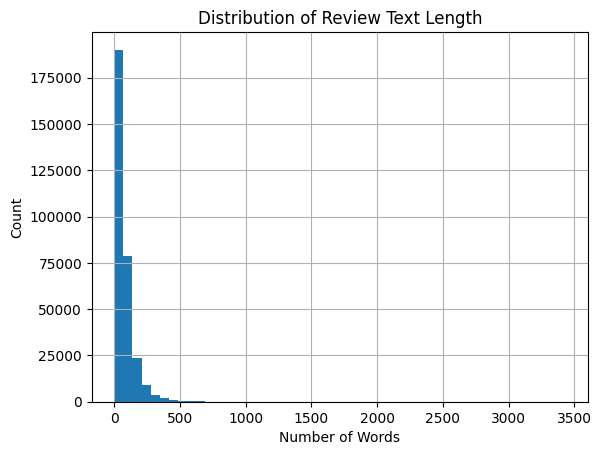

Some basic review stats:
Average word count: 79.75595459530102
Median word count: 57.0


In [6]:
# =============================
#  1.a Basic Data Exploration
# =============================

# Distribution of ratings
rating_counts = df_train['Score'].value_counts().sort_index()
print("Distribution of Ratings:\n", rating_counts)

# Plot the distribution
plt.figure()
rating_counts.plot(kind='bar')
plt.title("Distribution of Ratings in the Training Set")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Basic text length statistics
df_train['review_length'] = df_train['Text'].apply(lambda x: len(str(x).split()))
plt.figure()
df_train['review_length'].hist(bins=50)
plt.title("Distribution of Review Text Length")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

print("Some basic review stats:")
print("Average word count:", df_train['review_length'].mean())
print("Median word count:", df_train['review_length'].median())


# =============================
#  2. Text Processing / Normalization
# =============================
# We'll create a function to:
#   - Lowercase
#   - Remove punctuation
#   - Remove numeric characters
#   - Tokenize
#   - Remove stopwords
#   - Apply stemming or lemmatization: Prefer to use lemmatization as stemming can Often crude and imprecise, leading to words that can look incorrect (“amaz” for “amazed,” etc.).

In [8]:

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text, 
               remove_stopwords=True, 
               stem=False, 
               lemmatize=True):
    """
    Cleans the text with typical normalization steps.
    """
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # Remove numeric characters
    text = re.sub(r"\d+", "", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [w for w in tokens if w not in stop_words]
    
    if stem:
        tokens = [ps.stem(w) for w in tokens]
    
    if lemmatize:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
        
    return " ".join(tokens)


df_train['cleaned_review'] = df_train['Text'].apply(
    lambda x: clean_text(str(x), remove_stopwords=True, stem=False, lemmatize=True)
)

# Let's look at a few samples
df_train[['Text', 'cleaned_review']].head(5)


,Text,cleaned_review
0,I received this product early from the seller!...,received product early seller tastey great mid...
1,*****<br />Numi's Collection Assortment Melang...,br numi collection assortment melange includes...
2,"I was very careful not to overcook this pasta,...",careful overcook pasta making sure take bite e...
3,Buying this multi-pack I was misled by the pic...,buying multi pack misled picture whole hazel n...
4,These bars are so good! I loved them warmed up...,bar good loved warmed definitely think great s...


# =============================
#  3. Vector Space Model & Feature Representation
# =============================

# We will try a few approaches:
#   (a) CountVectorizer (with unigram, bigram, trigram)
#   (b) TfidfVectorizer
#   (c) Possibly binary representation or limiting max_features

# We'll define a quick function that returns a pipeline
# for a given vectorizer and classifier.

In [10]:


def create_pipeline(vectorizer, classifier):
    """
    Creates an sklearn pipeline that first vectorizes text,
    then applies a classifier.
    """
    pipe = Pipeline([
        ('vec', vectorizer),
        ('clf', classifier)
    ])
    return pipe

# Split the training data into train/validation
X = df_train['cleaned_review']
y = df_train['Score']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y)

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)


Training Set: (247304,) (247304,)
Validation Set: (61827,) (61827,)


# =============================
#  4. Model Training & Evaluation
# =============================

# Let's experiment with 3 classifiers:
#  1) LogisticRegression
#  2) Support Vector Machine (SVC)
#  3) RandomForestClassifier
#
# We will also try:
#  - CountVectorizer with n-grams
#  - TfidfVectorizer


In [12]:


# Grid search on one pipeline
def run_grid_search(pipe, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipe, param_grid, 
                               cv=3, # or 5
                               scoring='accuracy', 
                               verbose=1, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Params:", grid_search.best_params_)
    print("Best CV Score:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    return best_model

# 4.a Example for a Logistic Regression pipeline 
vec = CountVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5) 
clf = LogisticRegression(max_iter=200)
pipeline_lr = create_pipeline(vec, clf)

param_grid_lr = {
    'vec__ngram_range': [(1,1), (1,2)],   # unigrams or bigrams
    'vec__max_features': [5000, 10000, None],
    'clf__C': [0.1, 1, 10]
}
best_model_lr = run_grid_search(pipeline_lr, param_grid_lr, X_train, y_train)

# Evaluate on validation set
pred_val_lr = best_model_lr.predict(X_val)
print("Validation Accuracy (LogisticRegression):", accuracy_score(y_val, pred_val_lr))
print("Classification Report:\n", classification_report(y_val, pred_val_lr))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'clf__C': 0.1, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
Best CV Score: 0.7227218272918495
Validation Accuracy (LogisticRegression): 0.7248774807123102
Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.65      0.64      5704
           2       0.35      0.19      0.24      3258
           3       0.41      0.26      0.32      4659
           4       0.45      0.25      0.32      8775
           5       0.80      0.94      0.86     39431

    accuracy                           0.72     61827
   macro avg       0.53      0.46      0.48     61827
weighted avg       0.68      0.72      0.69     61827



# 4.b SVC pipeline

In [ ]:
vec_svc = TfidfVectorizer() 
clf_svc = SVC()

pipeline_svc = create_pipeline(vec_svc, clf_svc)

param_grid_svc = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__max_features': [5000, 10000],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear'],  # for text, linear is common, but try 'rbf' if you want
}
best_model_svc = run_grid_search(pipeline_svc, param_grid_svc, X_train, y_train)

# Evaluate on validation
pred_val_svc = best_model_svc.predict(X_val)
print("Validation Accuracy (SVC):", accuracy_score(y_val, pred_val_svc))
print("Classification Report:\n", classification_report(y_val, pred_val_svc))


Fitting 3 folds for each of 12 candidates, totalling 36 fits


# 4.c RandomForest pipeline

In [ ]:

vec_rf = CountVectorizer(binary=True) 
clf_rf = RandomForestClassifier()

pipeline_rf = create_pipeline(vec_rf, clf_rf)

param_grid_rf = {
    'vec__max_features': [1000, 5000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None]
}
best_model_rf = run_grid_search(pipeline_rf, param_grid_rf, X_train, y_train)

pred_val_rf = best_model_rf.predict(X_val)
print("Validation Accuracy (RandomForest):", accuracy_score(y_val, pred_val_rf))
print("Classification Report:\n", classification_report(y_val, pred_val_rf))


# =============================
#  5. Modeling Text as a Sequence (RNN/LSTM/Transformer)
# =============================

# In contrast to Bag-of-Words, let's build a sequence-based model (e.g., LSTM).
# We can use Keras Tokenizer to convert text to sequences.

In [ ]:
MAX_NUM_WORDS = 20000   # Only consider the top 20k words
MAX_SEQUENCE_LENGTH = 200  # We'll only consider the first 200 tokens of each review

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences so they are all the same length
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq   = pad_sequences(X_val_seq,   maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to something numeric (1..5). If they're already numeric, that's fine.
# Possibly we want one-hot encoding if we're doing a multi-class classification with a softmax.
num_classes = len(y.unique())

# Keras expects y to be one-hot if we use categorical crossentropy:
y_train_oh = tf.keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val - 1, num_classes=num_classes)

print("Sequence shape:", X_train_seq.shape)
print("One-hot label shape:", y_train_oh.shape)

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=MAX_NUM_WORDS, 
                         output_dim=128,  # embedding dimension
                         input_length=MAX_SEQUENCE_LENGTH))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_lstm.summary()

# Let's train the model
es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

history = model_lstm.fit(X_train_seq, y_train_oh,
                         batch_size=128,
                         epochs=5,
                         validation_data=(X_val_seq, y_val_oh),
                         callbacks=[es],
                         verbose=1)

# Evaluate on validation
val_loss, val_acc = model_lstm.evaluate(X_val_seq, y_val_oh)
print("LSTM Validation Accuracy:", val_acc)


# =============================
#  7. Topic Modeling (High vs Low Ratings)
# =============================
# We'll isolate 1-star and 5-star reviews, then use LDA or similar topic modeling approach.

In [ ]:


# Filter only 1-star or 5-star
df_one_star = df_train[df_train['rating'] == 1]
df_five_star = df_train[df_train['rating'] == 5]

# We can sample if they are too large
df_one_star_sample = df_one_star.sample(n=1000, random_state=42) \
    if df_one_star.shape[0] > 1000 else df_one_star
df_five_star_sample = df_five_star.sample(n=1000, random_state=42) \
    if df_five_star.shape[0] > 1000 else df_five_star

# Clean them if not already
# Let's assume df_train['cleaned_review'] has them. 
one_star_texts = [review.split() for review in df_one_star_sample['cleaned_review']]
five_star_texts = [review.split() for review in df_five_star_sample['cleaned_review']]

# Build dictionary and corpus for Gensim
dictionary_1 = corpora.Dictionary(one_star_texts)
dictionary_5 = corpora.Dictionary(five_star_texts)

# Filter out extreme words
dictionary_1.filter_extremes(no_below=5, no_above=0.5)
dictionary_5.filter_extremes(no_below=5, no_above=0.5)

corpus_1 = [dictionary_1.doc2bow(text) for text in one_star_texts]
corpus_5 = [dictionary_5.doc2bow(text) for text in five_star_texts]

# Let's pick 10 topics for demonstration
NUM_TOPICS = 10

lda_1 = gensim.models.ldamodel.LdaModel(corpus=corpus_1,
                                        id2word=dictionary_1,
                                        num_topics=NUM_TOPICS,
                                        random_state=42,
                                        passes=5)
lda_5 = gensim.models.ldamodel.LdaModel(corpus=corpus_5,
                                        id2word=dictionary_5,
                                        num_topics=NUM_TOPICS,
                                        random_state=42,
                                        passes=5)

print("Topics for 1-star reviews:")
for idx, topic in lda_1.print_topics(num_topics=NUM_TOPICS, num_words=5):
    print(f"Topic {idx}: {topic}")

print("\nTopics for 5-star reviews:")
for idx, topic in lda_5.print_topics(num_topics=NUM_TOPICS, num_words=5):
    print(f"Topic {idx}: {topic}")

# You would interpret these topics in your report,
# highlighting differences between the two sets.
